#Original model

In [0]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# learning rate tuning during learning

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 25:
        lrate = 0.0005
    if epoch > 50:
        lrate = 0.0003        
    return lrate


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#z-score
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

weight_decay = 1e-4
model = tf.keras.models.Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

# training
batch_size = 64

opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])


Using TensorFlow backend.


170500096/170498071 [==============================] - 13s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
______________________________________________________

In [0]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=75,
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

# save to disk
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model.h5')    

# testing
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))



Epoch 1/75
781/781 [==============================] - 27s 35ms/step - loss: 1.5990 - accuracy: 0.5089 - val_loss: 1.3153 - val_accuracy: 0.5957 - lr: 0.0010
Epoch 2/75
781/781 [==============================] - 27s 34ms/step - loss: 1.3134 - accuracy: 0.6012 - val_loss: 1.1305 - val_accuracy: 0.6452 - lr: 0.0010
Epoch 3/75
781/781 [==============================] - 26s 34ms/step - loss: 1.1222 - accuracy: 0.6525 - val_loss: 0.9169 - val_accuracy: 0.7242 - lr: 0.0010
Epoch 4/75
781/781 [==============================] - 26s 34ms/step - loss: 0.9933 - accuracy: 0.6899 - val_loss: 1.0167 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 5/75
781/781 [==============================] - 26s 34ms/step - loss: 0.9209 - accuracy: 0.7163 - val_loss: 0.8584 - val_accuracy: 0.7440 - lr: 0.0010
Epoch 6/75
781/781 [==============================] - 26s 33ms/step - loss: 0.8696 - accuracy: 0.7355 - val_loss: 0.7446 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 7/75
781/781 [==============================] - 26s 

In [0]:
# reform y_test

y_test = [np.argmax(i) for i in y_test]

#Test code about how TFLite works

In [0]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
    ])

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)



11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2908 - accuracy: 0.9149
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1401 - accuracy: 0.9587
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1056 - accuracy: 0.9681
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0855 - accuracy: 0.9732
Epoch 5/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0743 - accuracy: 0.9768


0


In [0]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#========================== NO QUANTIZATION ===========================

tflite_models_dir = pathlib.Path("/content/gdrive/My Drive/BNN_works/quant models")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model = converter.convert()

print("1. no quant, size: ", tflite_model_file.write_bytes(tflite_model))

#===== 8 - bit SOFT QUANTIZATION (maybe not all would be quantized)=====

mnist_train, _ = tf.keras.datasets.mnist.load_data()
images = tf.cast(mnist_train[0], tf.float32) / 255.0
mnist_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)

def representative_data_gen():
  for input_value in mnist_ds.take(100):
    yield [input_value]

converter.representative_dataset = representative_data_gen
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant.tflite"
print("2. 8 bit quant, size: ",tflite_model_quant_file.write_bytes(tflite_model_quant))

#================== 8 - bit QUANTIZATION with input & output ====================

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant_io.tflite"
print("3. add input/output quant 8-bit, size: ",tflite_model_quant_file.write_bytes(tflite_model_quant))

1. no quant, size:  408436
2. 8 bit quant, size:  104368
3. add input/output quant 8-bit, size:  104368


Lets test original model

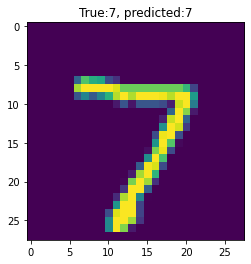

In [0]:
import numpy as np

interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

input_index_quant = interpreter_quant.get_input_details()[0]["index"]
output_index_quant = interpreter_quant.get_output_details()[0]["index"]

test_image = np.expand_dims(x_test[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

import matplotlib.pylab as plt

plt.imshow(x_test[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(y_test[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

And now the quantized model

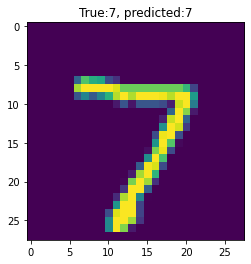

In [0]:
input_index = interpreter_quant.get_input_details()[0]["index"]
output_index = interpreter_quant.get_output_details()[0]["index"]
interpreter_quant.set_tensor(input_index, test_image)
interpreter_quant.invoke()
predictions = interpreter_quant.get_tensor(output_index)

plt.imshow(x_test[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(y_test[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)

Function to evaluate model

In [0]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in x_test:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == y_test[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

print(evaluate_model(interpreter))            # float -32
print(evaluate_model(interpreter_quant))      # int - 8

0.9784
0.9778


#Original model quantization

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#========================== NO QUANTIZATION ===========================

tflite_models_dir = pathlib.Path("/content/gdrive/My Drive/BNN_works/QCIFAR10")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"C10.tflite"
tflite_model = converter.convert()
print("1. no quant, size: ", tflite_model_file.write_bytes(tflite_model))

#===== 8 - bit SOFT QUANTIZATION (maybe not all would be quantized)=====

converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"QC10.tflite"
print("2. 8 bit quant, size: ",tflite_model_quant_file.write_bytes(tflite_model_quant))

#================== 8 - bit QUANTIZATION with input & output ====================

cif_train, _ = tf.keras.datasets.cifar10.load_data()
images = tf.cast(cif_train[0], tf.float32) / 255.0
cif_ds = tf.data.Dataset.from_tensor_slices((images)).batch(1)

def representative_data_gen():
  for input_value in cif_ds.take(100):
    yield [input_value]

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"mnist_model_quant_io.tflite"
print("3. add input/output quant 8-bit, size: ",tflite_model_quant_file.write_bytes(tflite_model_quant))


#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#tflite_model_quant = converter.convert()

1. no quant, size:  1240372
2. 8 bit quant, size:  322136
3. add input/output quant 8-bit, size:  334224


[[5.14743803e-08 1.74479617e-04 3.18436494e-13 7.74670855e-13
  1.42972013e-14 1.03394215e-13 1.00458877e-12 1.08908183e-13
  9.99825537e-01 5.95770828e-08]]
[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9]


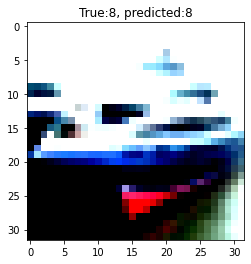

In [0]:
import numpy as np


interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

input_index_quant = interpreter_quant.get_input_details()[0]["index"]
output_index_quant = interpreter_quant.get_output_details()[0]["index"]

test_image = np.expand_dims(x_test[1], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]
interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)
print(predictions)
import matplotlib.pylab as plt

plt.imshow(x_test[1])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(y_test[1]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)
print(y_test[0:15])

In [0]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in x_test:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == y_test[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

print(evaluate_model(interpreter))            # float -32
print(evaluate_model(interpreter_quant))      # int - 8

0.8804


[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
